In [1]:
import os
import toml
import gokart
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import toml
from pipelines import HypergradEstimationPipeline
from luigi.configuration.toml_parser import LuigiTomlParser
import matplotlib as mpl

os.environ['LUIGI_CONFIG_PARSER'] = 'toml'


In [ ]:
from conf.paper_adult import get_config as config_adult
from conf.paper_fashion import get_config as config_fashion
from conf.paper_synth import get_config as config_synth

configs = {
    # 'synth': config_synth,
    'adult': config_adult,
    # 'fashion': config_fashion,
}

settings = [
    "neumann",
    "unroll",
    "vr_no_km",
    "grazzi_const",
    "vr_km_const",
    "grazzi_linear",
    "vr_km_linear",
]


In [3]:
results = {}
params = {}
for key, get_config in configs.items():
    config = get_config()

    os.makedirs('.tmp', exist_ok=True)
    with open(f'.tmp/params_ipynb_{key}_20250224.toml', 'w') as f:
        toml.dump(config, f)

    gokart.add_config(f'.tmp/params_ipynb_{key}_20250224.toml')
    # task_pipeline = gokart.build(HypergradEstimationPipeline(), return_value=True)
    task_pipeline = HypergradEstimationPipeline()
    task_plot, _, _ = task_pipeline.requires()

    result = task_plot.load()['task_sample']
    labels = list(result.keys())
    label_to_setting = {}
    for label in labels:
        for s in settings:
            if s in label:
                label_to_setting[label] = s
                break

    params_all = {label: (method, param) for label, method, param in zip(config['HypergradEstimationPipeline']['labels'],config['HypergradEstimationPipeline']['methods'], config['HypergradEstimationPipeline']['params'])}
    params_method = {label_to_setting[label]: params_all[label][1] for label in labels}
    params[key] = params_method

    for label, result in result.items():
        if key not in results:
            results[key] = {}
        method = label_to_setting[label]
        results[key][method] = result

    # remove config file and reload
    LuigiTomlParser._config_paths.pop(-1)
    LuigiTomlParser.reload()

./resources/GetGoodResults_77857febd39e978a428334fc49bb6945.pt


adult: (np.float64(0.00043892147560403813), np.float64(0.21728527090334268))


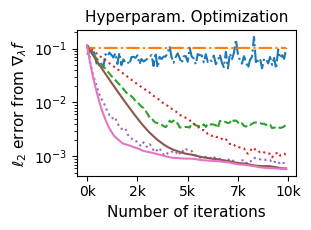

In [ ]:
xlabel = 'Number of iterations'
ylabel = r'$\ell_2$ error from $\nabla_\lambda f$'
xscale = 'linear'
yscale = 'log'
output_dir = './results/'

setting_to_legend = {
    "neumann": "StocFP",
    "unroll": "StocRB",
    "vr_no_km": "MixedFP",
    "grazzi_const": "StocFP+KM→ (StocFP + KM-iteration with constant η)",
    "grazzi_linear": "StocFP+KM↓ (StocFP + KM-iteration with decreasing η)",
    "vr_km_const": "MixedFP+KM→ (MixedFP-KM with constant η)",
    "vr_km_linear": "MixedFP+KM↓ (MixedFP-KM with decreasing η)",
}

setting_to_linestyle = {
    "neumann": "-.",
    "unroll": "-.",
    "vr_no_km": "--",
    "grazzi_const": ":",
    "grazzi_linear": ":",
    "vr_km_const": "-",
    "vr_km_linear": "-",
}

task_to_title = {
    'synth': 'Synthetic Problem',
    'adult': 'Hyperparam. Optimization',
    'fashion': 'Influence Estimation',
}
task_to_ylims = {
    'synth': (0.4106502202069305, 125.73533196383967),
    'adult': (0.00043892147560403813, 0.21728527090334268),
    'fashion': (2.869656533985987e-05, 0.0004175475824427361),
}

no_fill = [
    ('adult', 'neumann'),
    ('adult', 'vr_no_km'),
]

from matplotlib.ticker import FuncFormatter
def thousands_formatter(x, pos):
    return f'{int(x/1000)}k'

scale = 0.8
fontsize = 11
plot_every = 100
for task, result in results.items():
    param = params[task]

    fig, ax = plt.subplots(figsize=(4*scale, 3*scale))
    # Ensure grid is not shown
    ax.grid(False)

    for method, label in setting_to_legend.items():
        res = result[method]
        # param_ = param[method]  # Uncomment if you need to use parameters for further customization.
        means = res['mean']
        xs = np.arange(0, len(means), plot_every)
        ys = means[xs]

        ax.plot(xs, ys, label=label, linestyle=setting_to_linestyle[method])

        # if (task, method) in no_fill:
        #     alpha = 0.1
        # else:
        #     alpha = 0.2
        # stds = res['std'][xs]
        # ax.fill_between(xs, ys - stds, ys + stds, alpha=alpha)
    # title
    ax.set_title(task_to_title[task], fontsize=fontsize)
    ax.set_xscale(xscale)
    ax.set_yscale(yscale)
    ax.set_ylabel(ylabel, fontsize=fontsize)
    ax.set_xlabel(xlabel, fontsize=fontsize)
    print(f'{task}: {ax.get_ylim()}')
    # ax.set_ylim(task_to_ylims[task])
    # ax.legend()
    ax.xaxis.set_major_formatter(FuncFormatter(thousands_formatter))

    fig.tight_layout()
    os.makedirs(output_dir, exist_ok=True)
    pdf_path = os.path.join(output_dir, f'{task}.pdf')
    fig.savefig(pdf_path)
    # print ylims
    plt.show()

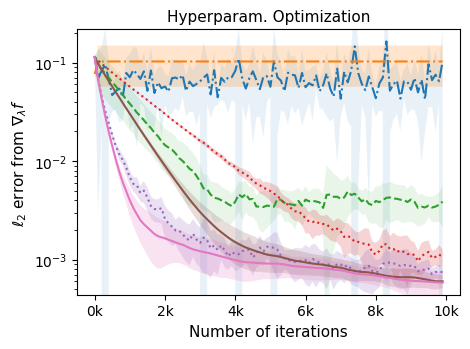

In [5]:
scale = 1.2
fontsize = 11
plot_every = 100
for task, result in results.items():
    param = params[task]

    fig, ax = plt.subplots(figsize=(4*scale, 3*scale))
    # Ensure grid is not shown
    ax.grid(False)

    for method, label in setting_to_legend.items():
        res = result[method]
        # param_ = param[method]  # Uncomment if you need to use parameters for further customization.
        means = res['mean']
        xs = np.arange(0, len(means), plot_every)
        ys = means[xs]

        ax.plot(xs, ys, label=label, linestyle=setting_to_linestyle[method])

        if (task, method) in no_fill:
            alpha = 0.1
        else:
            alpha = 0.2
        stds = res['std'][xs]
        ax.fill_between(xs, ys - stds, ys + stds, alpha=alpha)
    # title
    ax.set_title(task_to_title[task], fontsize=fontsize)
    ax.set_xscale(xscale)
    ax.set_yscale(yscale)
    ax.set_ylabel(ylabel, fontsize=fontsize)
    ax.set_xlabel(xlabel, fontsize=fontsize)
    # print(f'{task}: {ax.get_ylim()}')
    ax.set_ylim(task_to_ylims[task])
    # ax.legend()
    ax.xaxis.set_major_formatter(FuncFormatter(thousands_formatter))

    fig.tight_layout()
    os.makedirs(output_dir, exist_ok=True)
    pdf_path = os.path.join(output_dir, f'{task}_w_errorbars_large.pdf')
    fig.savefig(pdf_path)
    # print ylims
    plt.show()

In [6]:
def get_legend(labels, markers=None, colors=None, styles=None, markersizes=None, ncol=1):
    if markersizes is None:
        markersizes = [None] * len(labels)
    if styles is None:
        styles = [None] * len(labels)
    if colors is None:
        colors = [None] * len(labels)
    if markers is None:
        markers = [None] * len(labels)

    assert len(labels) == len(markers) == len(colors)

    fig, ax = plt.subplots()
    for label, marker, color, style, markersize in zip(labels, markers, colors, styles, markersizes):
        ax.plot(np.ones(1), np.ones(1), label=label, marker=marker, color=color, linestyle=style, markersize=markersize)
    legends = []
    for line, line_name in zip(*fig.axes[0].get_legend_handles_labels()):
        legends.append(line)
    fig2 = plt.figure()
    ax2 = fig2.add_subplot()
    ax2.axis('off')
    legend = ax2.legend(legends, labels, frameon=False, loc='lower center', ncol=ncol)
    fig_legend = legend.figure
    fig_legend.canvas.draw()

    return legend

def get_tight_legend_bbox_inches(legend):
    bbox = legend.get_window_extent().transformed(legend.figure.dpi_scale_trans.inverted())
    return bbox

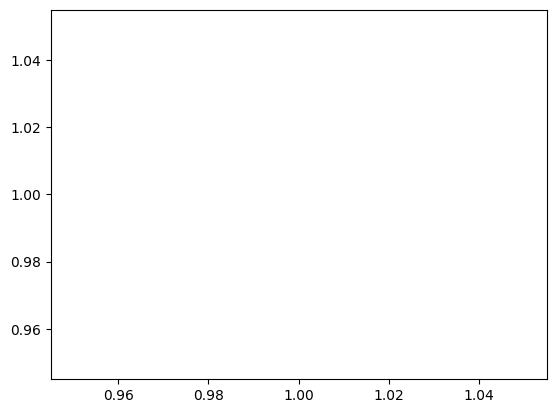

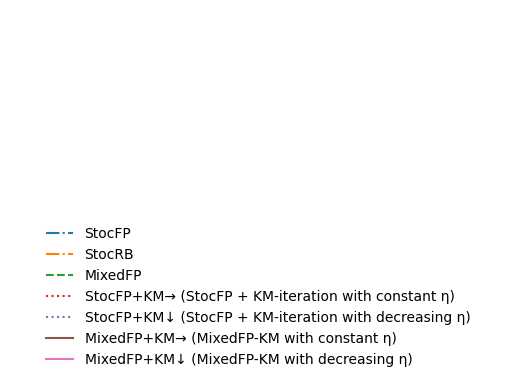

In [7]:
legend = get_legend(labels=setting_to_legend.values(), styles=setting_to_linestyle.values(), ncol=1)

bbox = get_tight_legend_bbox_inches(legend)
bbox = bbox.from_extents(bbox.xmin, bbox.ymin, bbox.xmax, bbox.ymax * 1.02)  # Increase the height by 20%

legend.figure.savefig(os.path.join(output_dir, f"legends.pdf"), dpi="figure", bbox_inches=bbox)
# legend.figure.savefig(os.path.join(out_dir, "legends_cleansing.pdf"), dpi="figure")
